In [2]:
import numpy as np, matplotlib.pyplot as plt, glob, pickle
import matplotlib.gridspec as gridspec
from matplotlib import animation
from qtool.utility import plot_pulse, NLI, qubit_subspace, bloch_vecs, tensor
from qutip import Bloch
# from qiskit.visualization.bloch import Bloch

# plt.rcParams.update({
#     "text.usetex": True,
# })

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.sans-serif": "Palatino",
#     "font.size": 14,

# })

#rc('font',**{'family':'serif','serif':['Palatino']})

def visualize(run, ep, num_transmon=2, num_level=3):
    qubit_indices_vec,_,_ = qubit_subspace(num_level,num_transmon)

    file = glob.glob(f'../data/ray_results/*{run}*/RLPulse*map*{chpt}*')
    assert len(file) == 1
    data = pickle.load(open(file[0], 'rb'))
    print(data['map'].shape)
    
def visualize_bloch(run, chpt, num_level=3, num_transmon=2,rl=True,savename=None,fps=2,skip=None):
    if rl:
        file = glob.glob(f'data/ray_results/*{run}*/RLPulse*map*{chpt}*')
    else:
        file = glob.glob(f'data/two_qubit_gate/theory_{run}_{chpt}*.pkl')
    if len(file) != 1:
        print(file)
        raise ValueError
    data = pickle.load(open(file[0], 'rb'))

    qubit_indices_vec,_,_ = qubit_subspace(num_level,num_transmon)
    zero = np.eye(num_level,dtype=int)[0]
    one = np.eye(num_level,dtype=int)[1]
    ket00 = np.outer(zero,zero).flatten()
    ket10 = np.outer(one,zero).flatten()

    Us = data['map']
    Usket00 =  (Us@ket00)[:,qubit_indices_vec]
    Usket10 =  (Us@ket10)[:,qubit_indices_vec]

    fig = plt.figure(figsize=(7,4))
    for q_idx in range(num_transmon):
        ax = fig.add_subplot(1,num_transmon,q_idx+1,projection='3d')
        b = Bloch(axes=ax)
        b.point_marker = ['','^','o']
        b.point_size = [0,15,25]
        b.point_color = ['b','b','b','r','r','r']         
        for kets in [Usket00, Usket10]:       
            vecs = bloch_vecs(kets, q_idx)
            b.add_points(vecs,'l',alpha=0.5)
            b.add_points(vecs[:,10])
            b.add_points(vecs[:,-1])
        b.render() #title=f'qubit {q_idx}')
        plt.tight_layout()
    plt.show()
    
    if savename:
        fig = plt.figure(figsize=(7,4))
        b = []
        vecs00 = []
        vecs10 = []
        for j in range(num_transmon):
            ax = fig.add_subplot(1,num_transmon,j+1,projection='3d')
            b.append(Bloch(axes=ax))
            b[j].point_marker = ['','^','o']
            b[j].point_size = [0,15,25]
            b[j].point_color = ['b','b','b','r','r','r']         
            vecs00.append(bloch_vecs(Usket00, j))
            vecs10.append(bloch_vecs(Usket10, j))
        vecs00 = np.array(vecs00)
        vecs10 = np.array(vecs10)

        def animate(i):
            # if 
            if i>=Us.shape[0]: # or (skip and i!=0 and i!=Us.shape[0] and (i+1)%skip!=0):
                # for j in range(num_transmon):
                #     b[j].render()
                return 0
            for j in range(num_transmon):
                b[j].clear()
                b[j].add_points(vecs00[j][:,:i+1],'l',alpha=0.5)
                b[j].add_points(vecs00[j][:,i])
                b[j].add_points(vecs00[j][:,-1])
                b[j].add_points(vecs10[j][:,:i+1],'l',alpha=0.5)
                b[j].add_points(vecs10[j][:,i])
                b[j].add_points(vecs10[j][:,-1])
                b[j].render()#title=f'qubit {j}')
            plt.tight_layout()
        # ani = animation.FuncAnimation(fig, animate, np.arange(int(Us.shape[0]*1.2)), blit=False)
        if skip:
            frames = np.hstack([np.arange(Us.shape[0])[::-skip][::-1],
                                np.arange(Us.shape[0],int(Us.shape[0]*1.1))[::skip]])
        else:
            frames = np.arange(int(Us.shape[0]*1.1))
        ani = animation.FuncAnimation(fig, animate, frames, blit=False)
        ani.save(f'movies/{savename}.gif',fps=fps)
        plt.close()

Qiskit not found. Some pulse shapes are not available.


# Bloch

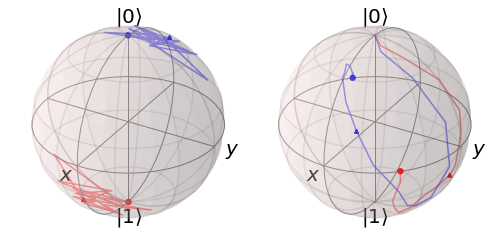

In [2]:
run, ep = '0392', '4200'
# visualize_bloch(run, ep, savename=f'ZXp90_1120dt_chan12_run{run}_ep{ep}_worst')
visualize_bloch(run, ep)

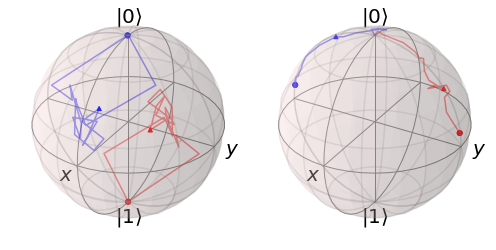

In [5]:
run, ep = '8639', '2400'
visualize_bloch(run, ep, savename=f'ZXp90_720dt_chan12_run{run}_ep{ep}')
# visualize_bloch(run, ep)

# Trajectories

In [4]:
def plot_trajectory(run, chpt, num_level=3, num_transmon=2,rl=True,savename=None,init_state='0'):
    if rl:
        file = glob.glob(f'data/ray_results/*{run}*/RLPulse*map*{chpt}*')
    else:
        file = glob.glob(f'data/two_qubit_gate/theory_{run}_{chpt}*.pkl')
    if len(file) != 1:
        print(file)
        raise ValueError
    data = pickle.load(open(file[0], 'rb'))

    qubit_indices_vec,_,_ = qubit_subspace(num_level,num_transmon)
    zero = np.eye(num_level,dtype=int)[0]
    one = np.eye(num_level,dtype=int)[1]
    
    if init_state == '1':
        ket00 = np.outer(zero,one).flatten()
        ket10 = np.outer(one,one).flatten()
        
    elif init_state == '0':
        ket00 = np.outer(zero,zero).flatten()
        ket10 = np.outer(one,zero).flatten()
        ketp0 = (ket00 + ket10)/np.sqrt(2)# +0 state

    Us = data['map']
    Usket00 =  (Us@ket00)[:,qubit_indices_vec]
    Usket10 =  (Us@ket10)[:,qubit_indices_vec]
    Usketp0 =  (Us@ketp0)[:,qubit_indices_vec]
    
    vecs = np.array([bloch_vecs(Usket00, 1), bloch_vecs(Usket10, 1), bloch_vecs(Usketp0, 1)])
    angles = np.array([cartesian_to_angle(vec)[1:] for vec in vecs])
    
    plot_angles(angles,savename=savename)
    plot_entanglement(vecs,savename=savename)
    plot_xyz(vecs, version=1,savename=savename)
    plot_xyz(vecs, version=2,savename=savename)
    plot_xyz(vecs, version=3,savename=savename)
    
def plot_angles(angles, savename=None):
    fig, axs = plt.subplots(2,1,figsize=(6,4),sharex=True)
    colors = ['C0','C3']
    ylabels = ['$\\theta$','$\\phi$']
    for i in range(2):
        axs[i].plot(angles[0,i],'C0',label='00')
        axs[i].plot(angles[1,i],'C3',label='10')
        axs[i].plot(angles[2,i],'C2',label='+0')
        axs[i].set_ylabel(ylabels[i])
        axs[i].grid()
        if i==0:
            axs[i].legend()
            axs[i].set_yticks([0,np.pi/2,np.pi])
            axs[i].set_yticklabels([0,'$\\frac{\\pi}{2}$','$\\pi$'])
            axs[i].set_title('Target qubit angles')
        else:
            axs[i].set_xlabel('Time steps')
            axs[i].set_xticks(np.arange(0,21,2))
            # axs[i].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
            # axs[i].set_yticklabels(['$-\\pi$','$-\\frac{\\pi}{2}$',0,'$\\frac{\\pi}{2}$','$\\pi$'])
            axs[i].set_yticks([0,np.pi/2,np.pi,3*np.pi/2])
            axs[i].set_yticklabels([0,'$\\frac{\\pi}{2}$','$\\pi$','$\\frac{3\\pi}{2}$'])
    plt.tight_layout()
    if savename:
        plt.savefig(f'figs/{savename}_angles.png',dpi=200)
    else:
        plt.show()
    
def plot_entanglement(vecs, savename=None):
    plt.figure(figsize=(6,3))
    Rs = np.sqrt(((vecs[0]+vecs[1])**2).sum(0))
    rhos = 0.5*(I+np.einsum('mn,mij->nij',vecs[2],np.array([X,Y,Z])))
    rs = (vecs[2]**2).sum(0)
    # purities = np.einsum('mij,mji->m',rhos,rhos)
    e = np.linalg.eigh(rhos)[0]
    entropies = (-e*np.nan_to_num(np.log(e))).sum(1)

    plt.plot(1-Rs/2,label='1-R/2')
    plt.plot(1-rs,label='1-r')
    plt.plot(entropies/np.log(2),label='entropy/ln(2)')
    plt.xlabel('Time steps')
    plt.title('Entanglement')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    if savename:
        plt.savefig(f'figs/{savename}_entanglement.png',dpi=200)
    else:
        plt.show()
    
def plot_xyz(vecs, version=1, savename=None):
    if version==1:
        fig, axs = plt.subplots(3,1,figsize=(6,6),sharex=True)
        ylabels = ['00','10','+0']
        for i,ax in enumerate(axs):
            ax.plot(vecs[i].T,label=['X','Y','Z'])
            ax.set_ylim(-1.1,1.1)
            ax.set_ylabel(ylabels[i])
            ax.grid()
            if i == 0:
                ax.set_title('Target qubit coordinates')
            elif i == 2:
                ax.legend(ncol=3)
                ax.set_xlabel('Time steps')
        
    elif version==2:
        fig, axs = plt.subplots(3,1,figsize=(6,6),sharex=True)
        ylabels = ['X','Y','Z']
        for i,ax in enumerate(axs):
            ax.plot(vecs[0,i].T,'C0',label='00')
            ax.plot(vecs[1,i].T,'C3',label='10')
            ax.set_ylim(-1.1,1.1)
            ax.set_ylabel(ylabels[i])
            ax.grid()
            if i == 0:
                ax.set_title('Target qubit coordinates')
            elif i == 2:
                ax.legend(ncol=1)
                ax.set_xlabel('Time steps')
        
    elif version==3:
        plt.figure(figsize=(6,4))
        pauli_labels = ['X','Y','Z']
        init_state_labels = ['00','10']
        ls = ['','--',':']
        for i in range(2):
            for j in range(3):
                plt.plot(vecs[i,j],f'C{3*i}'+ls[j],label=pauli_labels[j]+'_'+init_state_labels[i])
        plt.legend(ncol=2)
        plt.title('Target qubit coordinates')
        plt.xlabel('Time steps')
        plt.ylabel('Expectation value')
        plt.grid()
        
    plt.tight_layout()        
    if savename:
        plt.savefig(f'figs/{savename}_xyz{version}.png',dpi=200)
    else:
        plt.show()
        
def cartesian_to_angle(xyz):
    x,y,z = xyz
    r = np.sqrt(x**2+y**2+z**2)
    theta = np.arccos(z/r)
    phi = np.sign(y)*np.arccos(np.nan_to_num(x/np.sqrt(x**2+y**2)))
    phi[phi<0] += 2*np.pi
    # phi = np.arccos(x/np.sqrt(x**2+y**2))
    return r,theta,phi

/tmp/ipykernel_11795/821439298.py:142: RuntimeWarning: invalid value encountered in true_divide
  phi = np.sign(y)*np.arccos(np.nan_to_num(x/np.sqrt(x**2+y**2)))


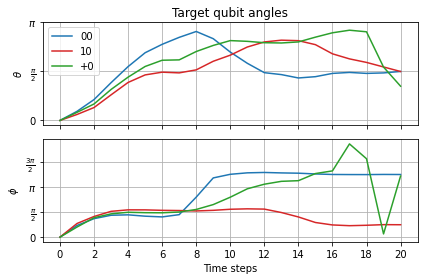

NameError: name 'I' is not defined

<Figure size 432x216 with 0 Axes>

In [5]:
run, chpt = '0392_4200'.split('_')
plot_trajectory(run, chpt)#, savename=f'ZXp90_1120dt_chan12_run{run}_ep{chpt}')